<center><h1> Intelligent Systems </h1>
    <h2> <b>Assignment #1</b> </h2>
    <h3> Done by: Ghinea Cristian and Varga Zoltan </h3></center>

<h3> Abstract </h3>
<p> We decided to examine a dataset which holds data about the shopping habits of citizens living in Istanbul. It holds data related to 10 shopping malls collected between 2021 and 2023. As the authors state it should provide a "comprehensive view of shopping habits in Istanbul".</p>
<p> The model built by us is able to predict <i> the likelihood of someone paying by credit card, debit card or cash. </i></p>
<p> <i>The dataset can be downloaded from here: <a href="https://www.kaggle.com/datasets/mehmettahiraslan/customer-shopping-dataset"> click here </a></i><p>

In [28]:
# Start by including some essential libraries

import pandas as pd
import numpy as np
import seaborn as sns


from pandas.plotting import scatter_matrix
from seaborn import scatterplot, heatmap

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import IterativeImputer


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.preprocessing import OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import ShuffleSplit

from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.metrics import mean_absolute_error

In [29]:
# read the dataset
df = pd.read_csv("./dataset/customer_shopping_data.csv")

<h3> Start by taking a look at our data </h3>

<p> 
    Here we can se that the types of the columns are as expected. This fact predicts us that there is no garbage (at least no mix of types within the columns).
</p>

In [30]:
df.columns

Index(['invoice_no', 'customer_id', 'gender', 'age', 'category', 'quantity',
       'price', 'payment_method', 'invoice_date', 'shopping_mall'],
      dtype='object')

In [31]:
df.dtypes

invoice_no         object
customer_id        object
gender             object
age                 int64
category           object
quantity            int64
price             float64
payment_method     object
invoice_date       object
shopping_mall      object
dtype: object

<p>
    This description gives us a better insight. The first two columns seem to be unique identifiers of the rows as there are as many unique values there as rows. The first decision of ours will be to delete these two columns because unique identifiers don't hold meaningful information.
</p>
<p>
    Going further, the remaining columns seem to have correct data, without any noise. We must mention that the age is neatly distributed, which is promising as this can be an important predictor.
</p>

In [32]:
df.describe(include="all")

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
count,99457,99457,99457,99457.000000,99457,99457.000000,99457.000000,99457,99457,99457
unique,99457,99457,2,NaN,8,NaN,NaN,3,797,10
top,I138884,C241288,Female,NaN,Clothing,NaN,NaN,Cash,24/11/2021,Mall of Istanbul
freq,1,1,59482,NaN,34487,NaN,NaN,44447,159,19943
mean,NaN,NaN,NaN,43.427089,NaN,3.003429,689.256321,NaN,NaN,NaN
std,NaN,NaN,NaN,14.990054,NaN,1.413025,941.184567,NaN,NaN,NaN
min,NaN,NaN,NaN,18.000000,NaN,1.000000,5.230000,NaN,NaN,NaN
25%,NaN,NaN,NaN,30.000000,NaN,2.000000,45.450000,NaN,NaN,NaN
50%,NaN,NaN,NaN,43.000000,NaN,3.000000,203.300000,NaN,NaN,NaN
75%,NaN,NaN,NaN,56.000000,NaN,4.000000,1200.320000,NaN,NaN,NaN


In [33]:
# delete the columns containing unique identifiers
df = df[['gender','age','category','quantity','price','payment_method','invoice_date','shopping_mall']]

In [34]:
# check what categories we have
df['category'].unique()

array(['Clothing', 'Shoes', 'Books', 'Cosmetics', 'Food & Beverage',
       'Toys', 'Technology', 'Souvenir'], dtype=object)

<p>
    We decided to encode the categories, however we might use one-hot encoding in the future.
</p>

In [35]:
df['category_num'] = 0
df.loc[df['category'] == 'Clothing', 'category_num'] = 0
df.loc[df['category'] == 'Shoes', 'category_num'] = 1
df.loc[df['category'] == 'Books', 'category_num'] = 2
df.loc[df['category'] == 'Cosmetics', 'category_num'] = 3
df.loc[df['category'] == 'Food & Beverage', 'category_num'] = 4
df.loc[df['category'] == 'Toys', 'category_num'] = 5
df.loc[df['category'] == 'Technology', 'category_num'] = 6
df.loc[df['category'] == 'Souvenir', 'category_num'] = 7

In [36]:
# check the payment methods
df['payment_method'].unique()

array(['Credit Card', 'Debit Card', 'Cash'], dtype=object)

In [37]:
df['payment_method_num'] = 0
df.loc[df['payment_method'] == 'Credit Card', 'payment_method_num'] = 0
df.loc[df['payment_method'] == 'Debit Card', 'payment_method_num'] = 1
df.loc[df['payment_method'] == 'Cash', 'payment_method_num'] = 2

In [38]:
df['shopping_mall'].unique()

array(['Kanyon', 'Forum Istanbul', 'Metrocity', 'Metropol AVM',
       'Istinye Park', 'Mall of Istanbul', 'Emaar Square Mall',
       'Cevahir AVM', 'Viaport Outlet', 'Zorlu Center'], dtype=object)

<p>
    As the names of the malls didn't provide us with any information, we opted to categorize them into two groups: expensive (0) and affordable (1) malls. We conducted research online to distinguish between the two.
</p>

In [39]:
df['mall_category'] = ''
df.loc[df['shopping_mall'] == 'Kanyon','mall_category'] = 0
df.loc[df['shopping_mall'] == 'Forum Istanbul','mall_category'] = 0
df.loc[df['shopping_mall'] == 'Metrocity','mall_category'] = 0
df.loc[df['shopping_mall'] == 'Metropol AVM','mall_category'] = 1
df.loc[df['shopping_mall'] == 'Istinye Park','mall_category'] = 0
df.loc[df['shopping_mall'] == 'Mall of Istanbul','mall_category'] = 1
df.loc[df['shopping_mall'] == 'Emaar Square Mall','mall_category'] = 0
df.loc[df['shopping_mall'] == 'Cevahir AVM','mall_category'] = 1
df.loc[df['shopping_mall'] == 'Viaport Outlet','mall_category'] = 1
df.loc[df['shopping_mall'] == 'Zorlu Center','mall_category'] = 0

In [40]:
df['gender_num'] = 0
df.loc[df['gender'] == 'Male', 'gender_num'] = 1

In [41]:
# categorise the years as the prefference of using debit/credit card or cash does not change over 1 year, but over a generation
df['age_cat'] = 0
df.loc[df['age'].between(18,23), 'age_cat'] = 1
df.loc[df['age'].between(23,26), 'age_cat'] = 2
df.loc[df['age'].between(26,33), 'age_cat'] = 3
df.loc[df['age'].between(33,37), 'age_cat'] = 4
df.loc[df['age'].between(47,57), 'age_cat'] = 5
df.loc[df['age'] > 57, 'age_cat'] = 6

<h3> Separate the test set and the training set </h3>

As in the followings we will dive deeper into the dataset we must lock the test set away. As we have plenty of data we can afford a 80% - 20% ratio between the size of the training and the test set.

In [42]:
dev_df, test_df = train_test_split(df, train_size=0.8, random_state=2)

<h3> Data visualization </h3>

In [43]:
copy_dev_df = dev_df.copy()

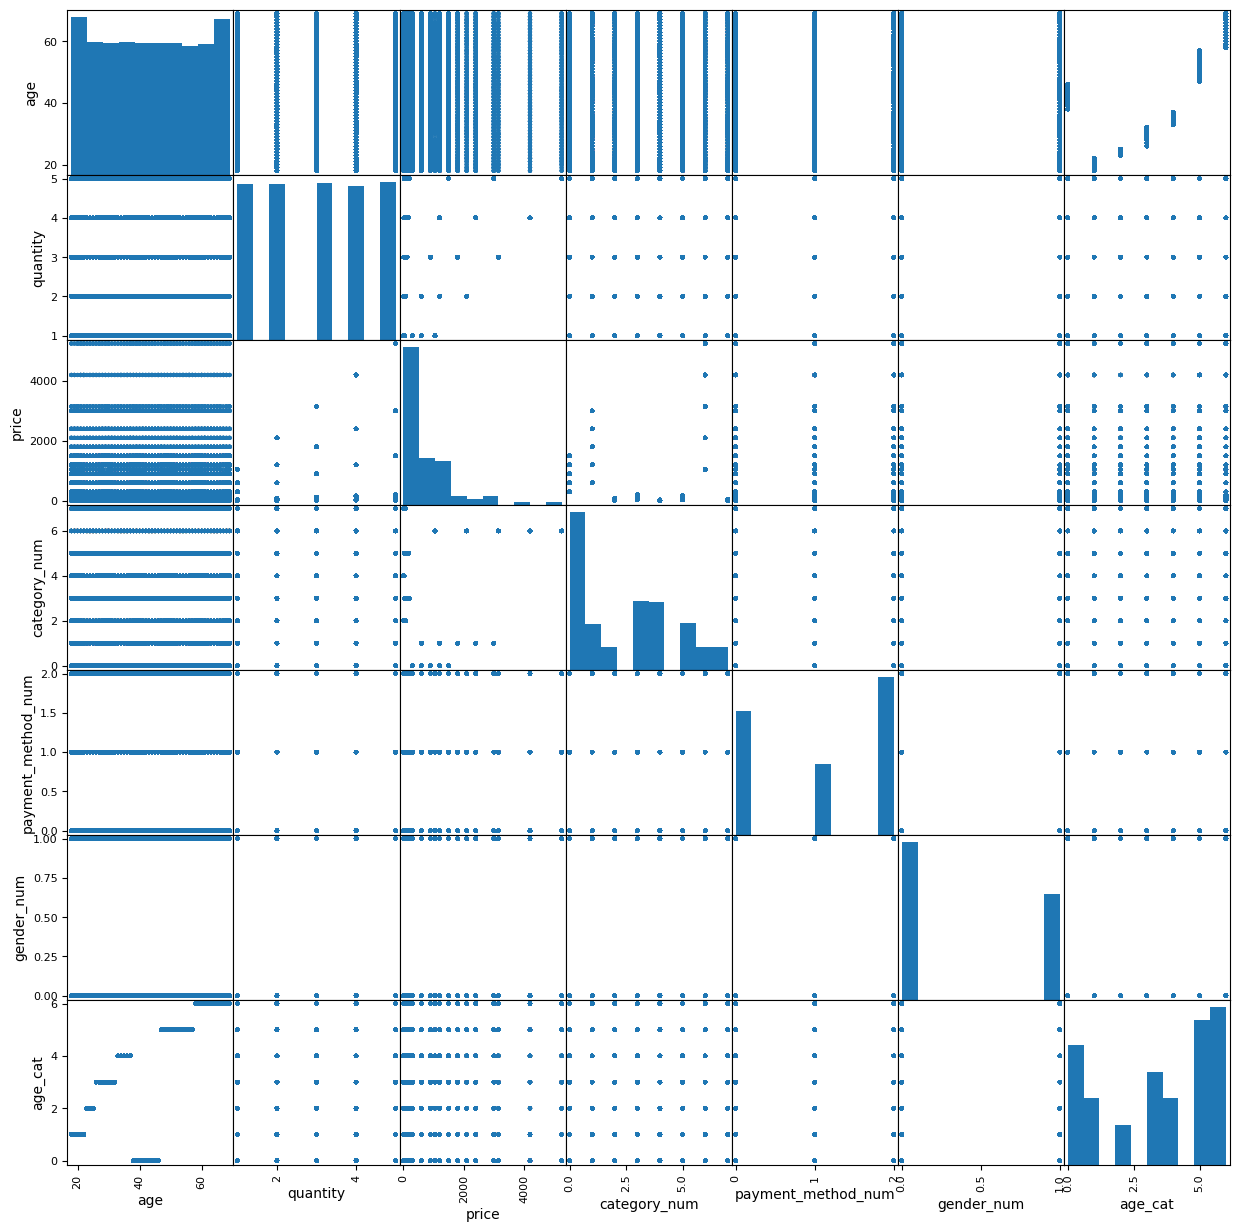

In [44]:
m = scatter_matrix(copy_dev_df,figsize=(15,15))

<Axes: xlabel='payment_method', ylabel='age'>

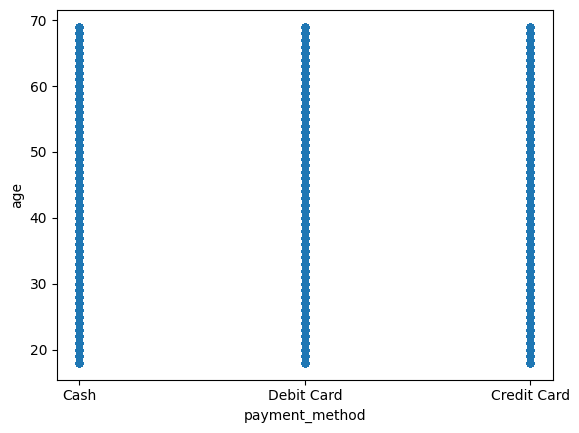

In [45]:
copy_dev_df.plot(kind="scatter", x="payment_method", y="age", alpha=0.1)

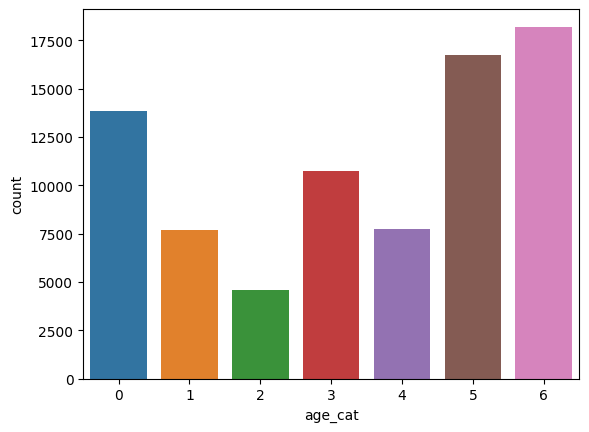

In [46]:
copy_dev_df.sort_values(by='age_cat', ascending=True)
sns.countplot(x = 'age_cat',
              data = copy_dev_df)

sns.set(rc={'figure.figsize':(15.7,25.27)})

Sansele sa cumpere cineva cu card sunt mai mari in jurul sarbatorilor din iarna (black-friday -> Christmas). Diferenta dintre current date si mean of [BF, Xmas].?? major turkish celebrations??

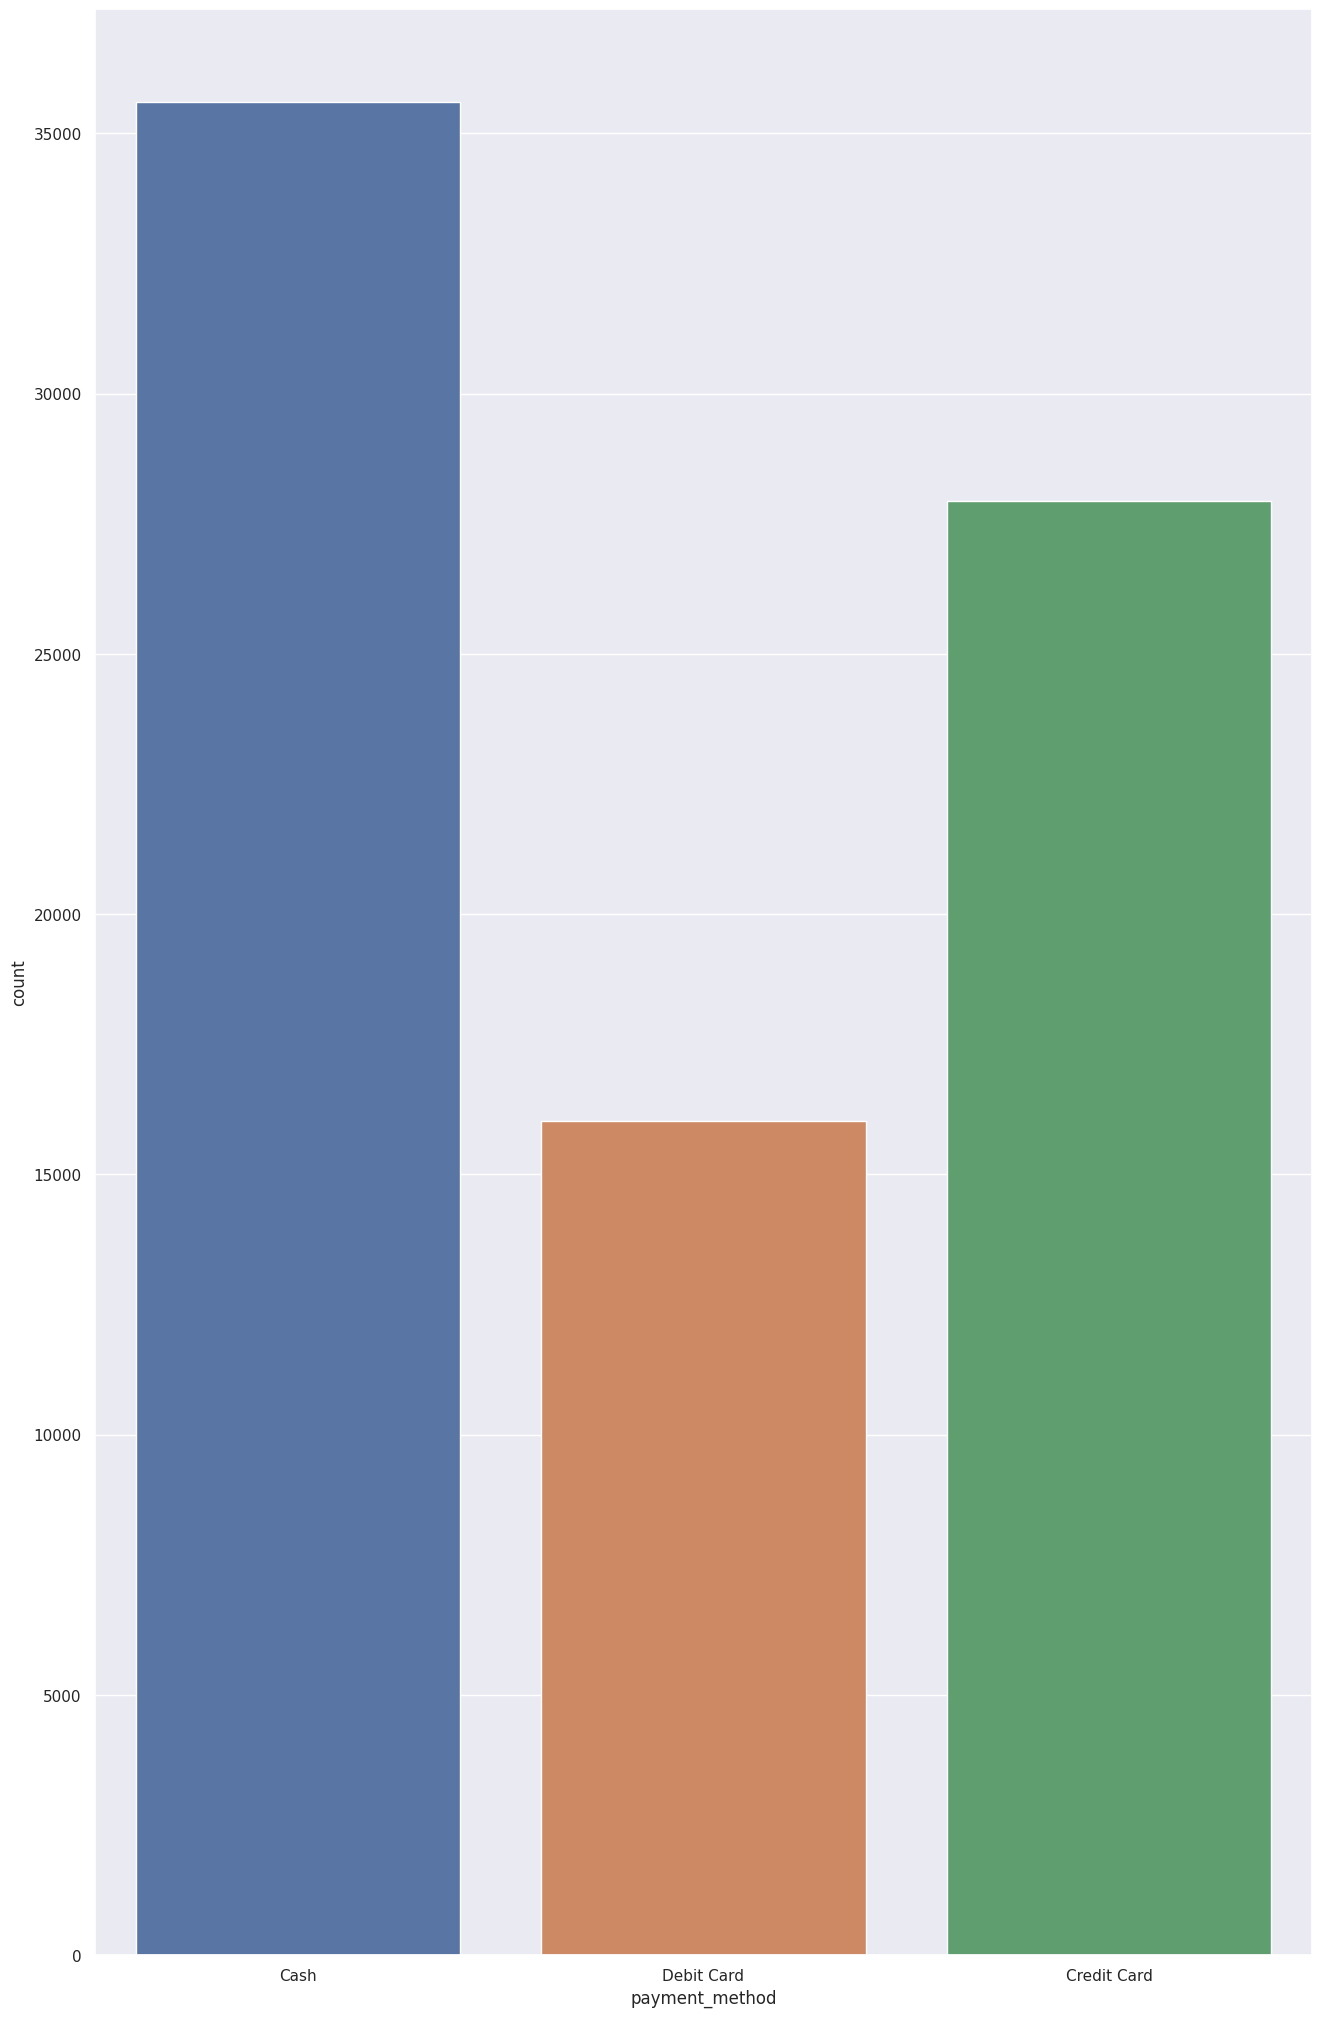

In [47]:
copy_dev_df.sort_values(by='payment_method', ascending=True)
sns.countplot(x = 'payment_method',
              data = copy_dev_df)

sns.set(rc={'figure.figsize':(15.7,25.27)})

<Axes: xlabel='payment_method', ylabel='price'>

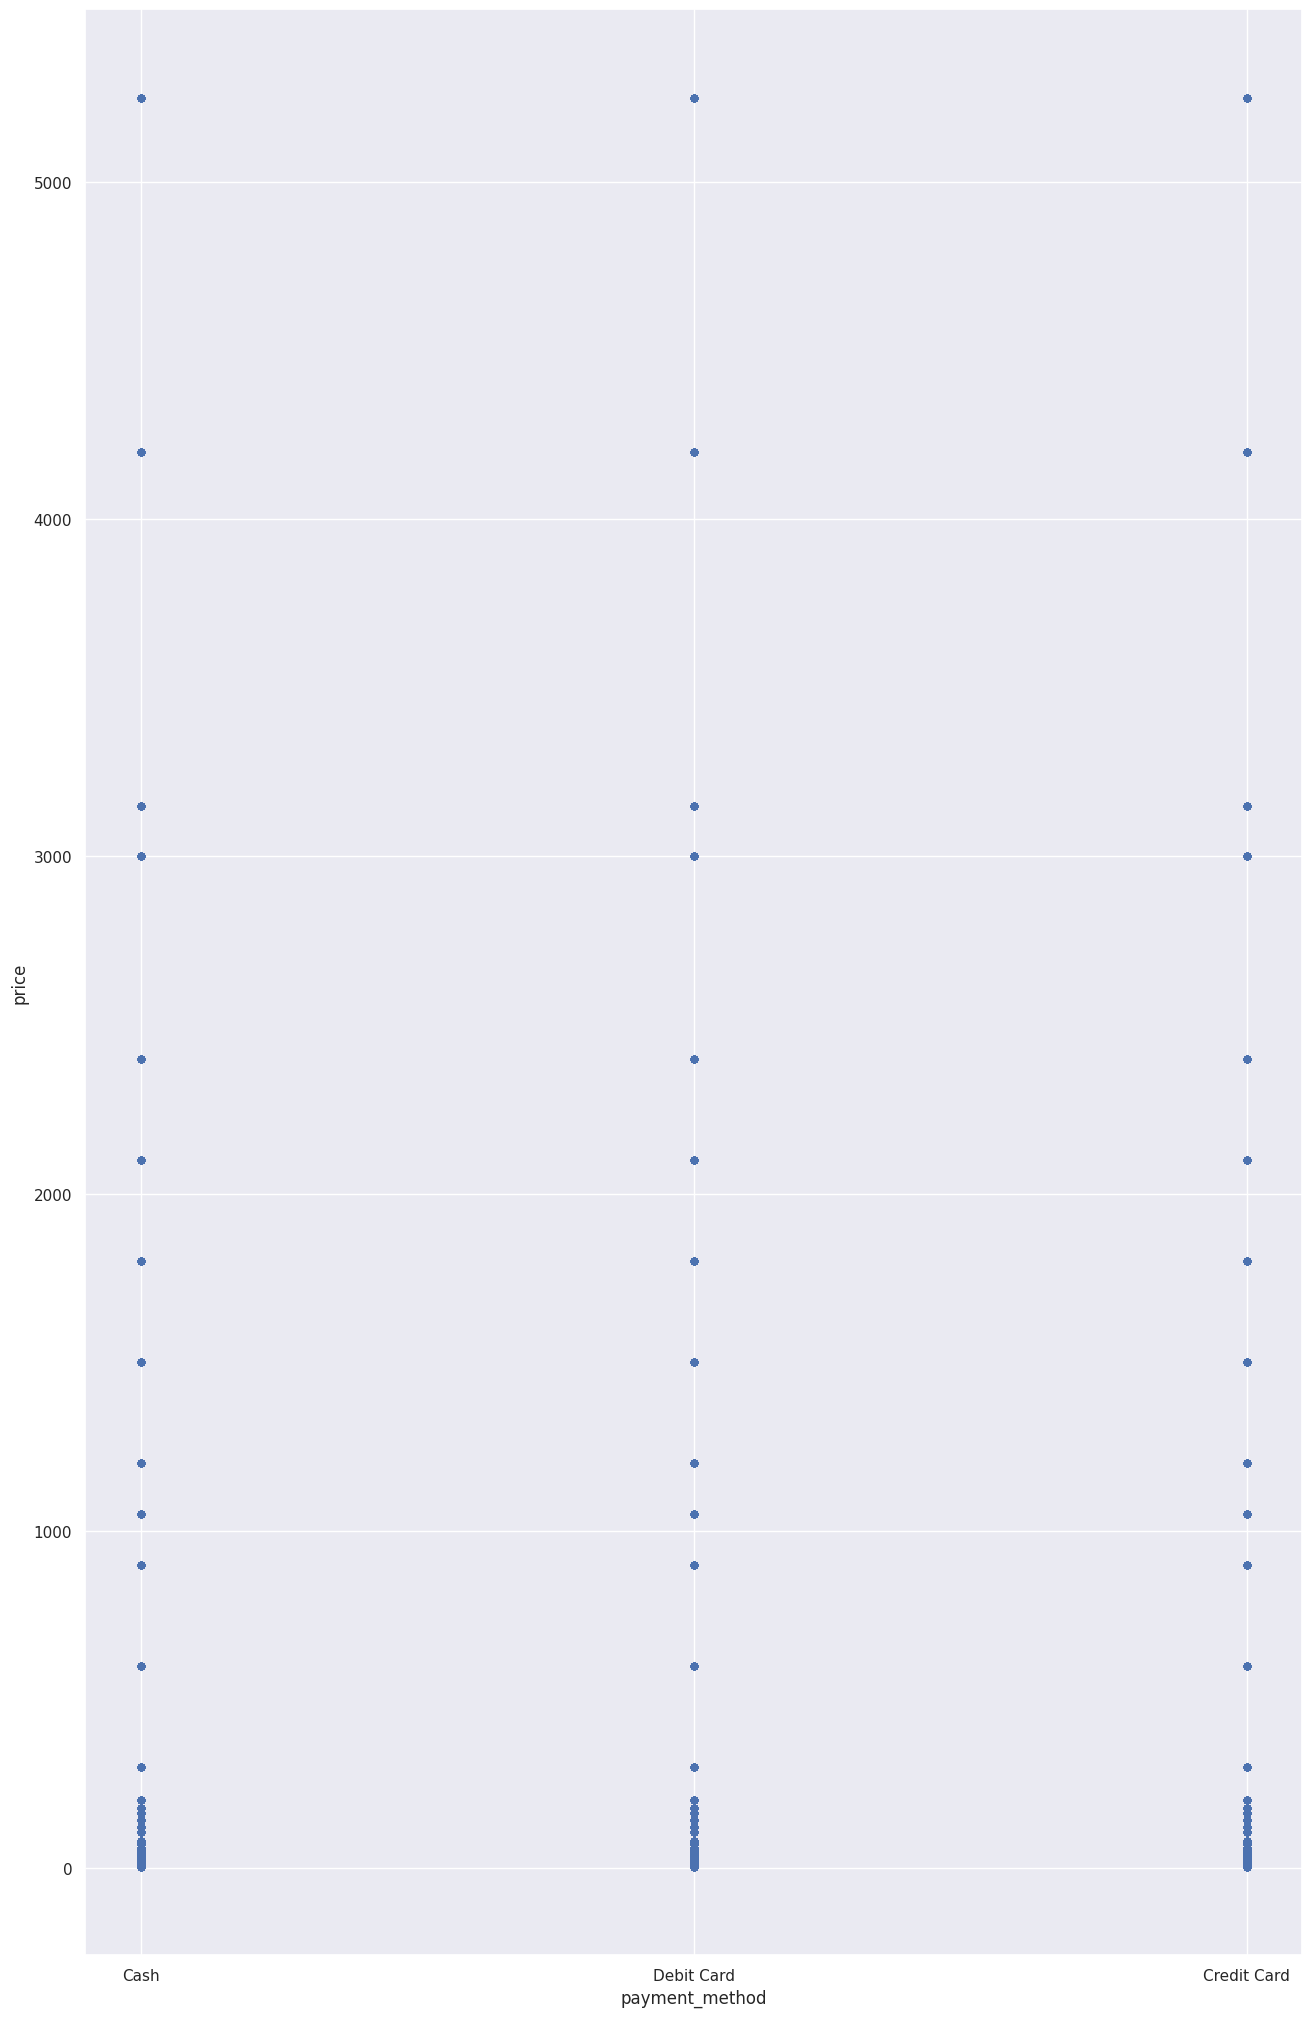

In [48]:
copy_dev_df.plot(kind="scatter", x="payment_method", y="price", alpha=0.1)